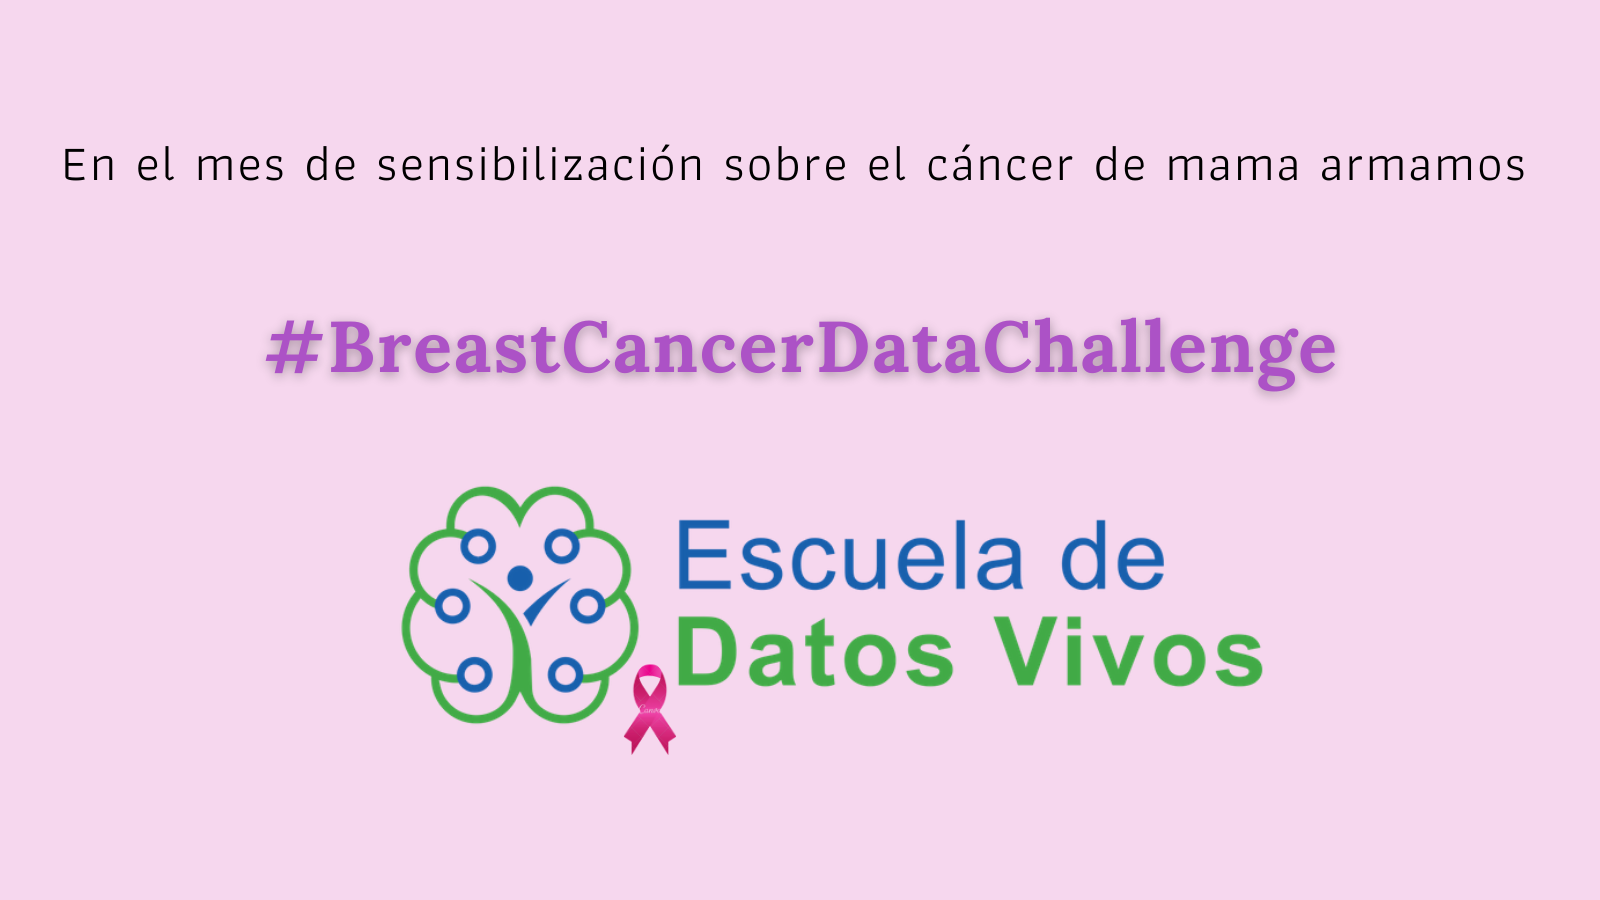

#### Este notebook es parte del desafio de <a href="https://escueladedatosvivos.ai/">Escuela de Datos Vivos</a> en el mes de la sencibilizacion sobre el cancer de mama

#### Para este proyecto se trabajo con el <a href="https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29">Breast Cancer Wisconsin data set</a> y se implementaron los siguientes features:

    1-Importacion y estado de salud del dataset
    
    2-EDA & correlaciones con la variable a predecir
    
    3-Implementacion de un modelo de ML en forma de benchmark
        a.Arbol de decisión
        
    4-Implementacion de tres modelos de ML con un tunning de los hiperparametros
          a.Arbol de decisión
          b.Vecinos mas cercanos
          c.Regresion logistica
    
    5-Conclusiones
    
    6-Anexo: threshold para todos los modelos

In [82]:
import pandas as pd
from funpymodeling.exploratory import status,freq_tbl,profiling_num
import seaborn as sns
import matplotlib.pyplot as plt
from qgrid import show_grid
from funpymodeling.exploratory import corr_pair
from minepy import MINE
import itertools
import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sklearn.metrics import precision_recall_fscore_support

# Parte 1: Importación y estado de salud del dataset

Importamos el dataset y hacemos una copia de los datos originales

In [83]:
df = pd.read_csv("C:/Users/Usuario/Desktop/Cursos/Data science python - EDV/Proyectos/Breast-cancer/Data/breast-cancer-wisconsin.csv")
df_original = df.copy()

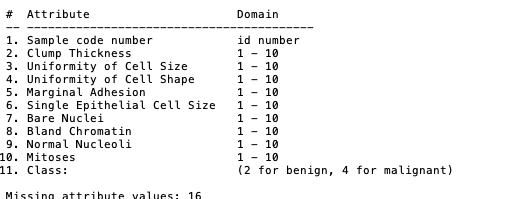

Mostramos las primeras 5 lineas del dataset

In [84]:
df.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [85]:
print(f"El dataset contiene {df.shape[0]} filas y  {df.shape[1]} columnas")

El dataset contiene 699 filas y  11 columnas


Analizamos una primera composicion de los datos con la funcion status de funpymodeling y show grid

In [86]:
status(df)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Sample code number,0,0.0,0,0.0,645,int64
1,Clump Thickness,0,0.0,0,0.0,10,int64
2,Uniformity of Cell Size,0,0.0,0,0.0,10,int64
3,Uniformity of Cell Shape,0,0.0,0,0.0,10,int64
4,Marginal Adhesion,0,0.0,0,0.0,10,int64
5,Single Epithelial Cell Size,0,0.0,0,0.0,10,int64
6,Bare Nuclei,0,0.0,0,0.0,11,object
7,Bland Chromatin,0,0.0,0,0.0,10,int64
8,Normal Nucleoli,0,0.0,0,0.0,10,int64
9,Mitoses,0,0.0,0,0.0,9,int64


In [87]:
show_grid(df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

#### Primeras observaciones:
1-Existen numeros de muestra duplicados (Sample code number)

2-Existen 16 valores nulos (?) en la variable Bare Nuclei

3-La clase predictora (Class) esta expresada en valores poco comunes (2 para benignos y 4 para malignos)


Quitamos los valores duplicados de la variable Sample code number

In [88]:
df.drop_duplicates(subset ="Sample code number", 
                     keep = "first", inplace = True)
print(f"Ahora el dataset contiene {df.shape[0]} filas y  {df.shape[1]} columnas")

Ahora el dataset contiene 645 filas y  11 columnas


Reemplazamos los valores nulos de la variable Bare Nuclei expresados con ? con un 0 y luego nos aseguramos que quede en un formato numerico

In [89]:
df["Bare Nuclei"].replace(to_replace =  "?", value = 0, inplace=True)
df["Bare Nuclei"] = df["Bare Nuclei"].astype(int)

Modificamos la variable Class para que quede 0 para los tumores benignos y 1 para los tumores malignos

In [90]:
df["Class"].replace({2: 0, 4: 1}, inplace=True)

Corroboramos los cambios realizados

In [91]:
status(df)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Sample code number,0,0.0,0,0.000000,645,int64
1,Clump Thickness,0,0.0,0,0.000000,10,int64
2,Uniformity of Cell Size,0,0.0,0,0.000000,10,int64
3,Uniformity of Cell Shape,0,0.0,0,0.000000,10,int64
4,Marginal Adhesion,0,0.0,0,0.000000,10,int64
5,Single Epithelial Cell Size,0,0.0,0,0.000000,10,int64
6,Bare Nuclei,0,0.0,16,0.024806,11,int32
7,Bland Chromatin,0,0.0,0,0.000000,10,int64
8,Normal Nucleoli,0,0.0,0,0.000000,10,int64
9,Mitoses,0,0.0,0,0.000000,9,int64


In [92]:
show_grid(df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

# Parte 2: EDA & correlaciones con la variable a predecir

Analizamos los estadisticos basicos de todas las variables numericas

In [93]:
profiling_num(df)

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,Sample code number,1.074419e+06,637262.659601,0.593123,145133.96,411622.4,871549.0,1171795.0,1238186.0,1333987.4,1368270.36
1,Clump Thickness,4.471318e+00,2.858115,0.639211,1.00,1.0,2.0,4.0,6.0,10.0,10.00
2,Uniformity of Cell Size,3.182946e+00,3.059049,0.961075,1.00,1.0,1.0,1.0,5.0,10.0,10.00
3,Uniformity of Cell Shape,3.269767e+00,2.985748,0.913138,1.00,1.0,1.0,2.0,5.0,10.0,10.00
4,Marginal Adhesion,2.893023e+00,2.918036,1.008646,1.00,1.0,1.0,1.0,4.0,10.0,10.00
5,Single Epithelial Cell Size,3.275969e+00,2.247455,0.686043,1.00,1.0,2.0,2.0,4.0,8.0,10.00
6,Bland Chromatin,3.497674e+00,2.459374,0.703145,1.00,1.0,2.0,3.0,5.0,8.0,10.00
7,Normal Nucleoli,2.955039e+00,3.120682,1.056055,1.00,1.0,1.0,1.0,4.0,10.0,10.00
8,Mitoses,1.613953e+00,1.744056,1.080611,1.00,1.0,1.0,1.0,1.0,5.8,10.00
9,Class,3.596899e-01,0.480282,1.335267,0.00,0.0,0.0,0.0,1.0,1.0,1.00


Graficamos un histograma de todas las variables numericas para complementar el entendimiento de sus distribuciones

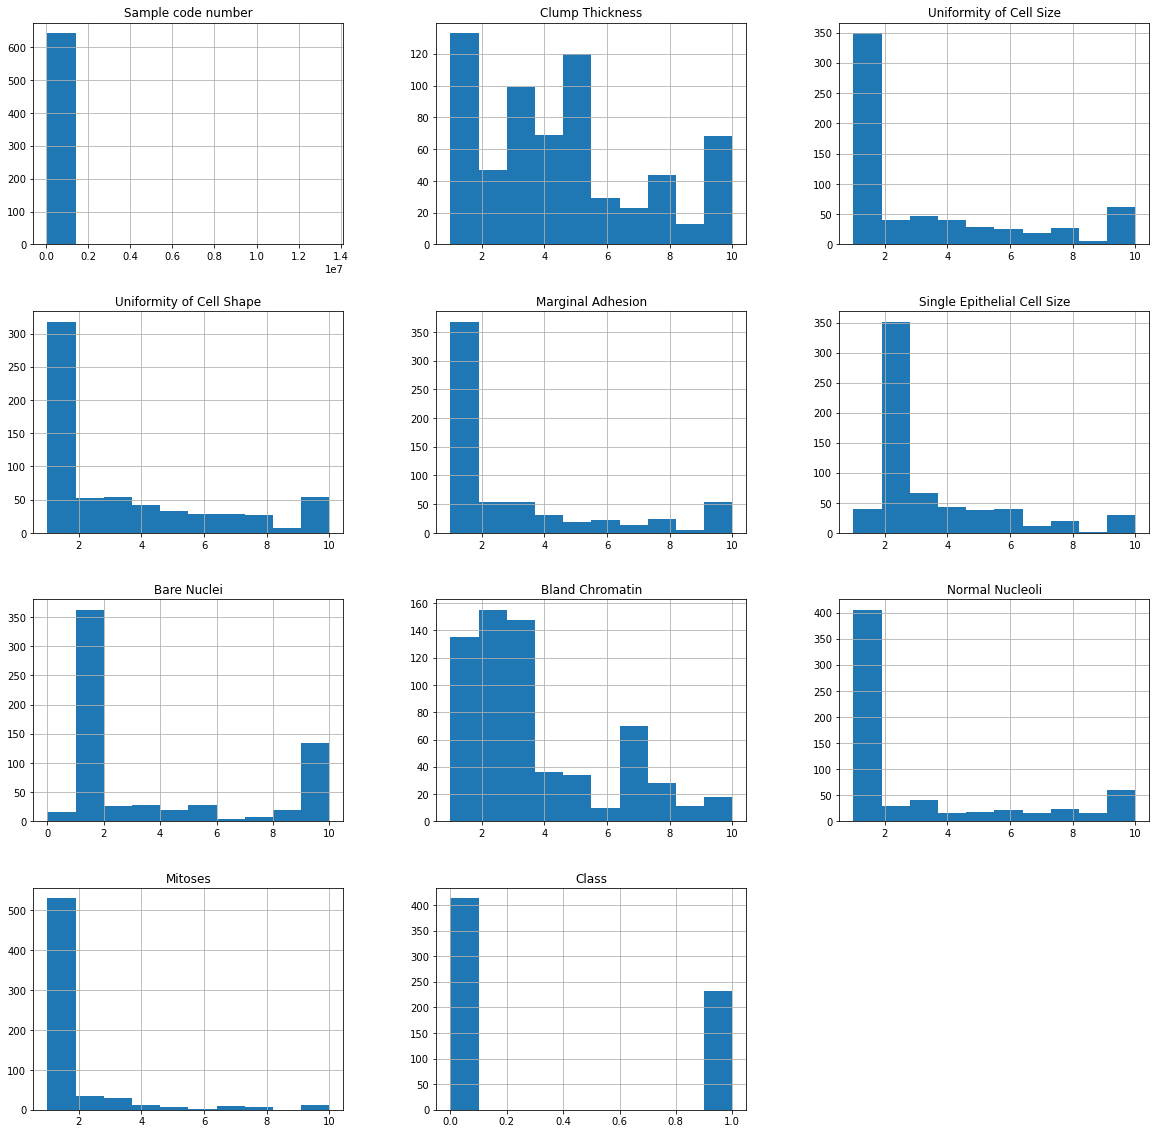

In [94]:
df.hist(figsize = (20,20))
plt.show()

Como conclusion, podemos observar que hay una dispersion baja en todas las variables, por lo que podemos suponer que hubo un procesamiento de datos anteriormente

Vamos a realizar el analisis de correlacion en base a dos teorias:

1-Correlacion de pearson: Para entender si hay una relacion lineal entre las variables

2-MIC: Para entender si hay una funcion que explique una relacion entre las distintas variables

1-Correlacion de pearson:

In [95]:
corr_pair(df).sort_values(ascending = False, by = "R").head(20).drop(columns = "R2")

,v1,v2,R
25,Uniformity of Cell Shape,Uniformity of Cell Size,0.903802
35,Uniformity of Cell Size,Uniformity of Cell Shape,0.903802
112,Uniformity of Cell Size,Class,0.817567
32,Class,Uniformity of Cell Size,0.817567
116,Bare Nuclei,Class,0.816032
76,Class,Bare Nuclei,0.816032
43,Class,Uniformity of Cell Shape,0.815828
113,Uniformity of Cell Shape,Class,0.815828
29,Bland Chromatin,Uniformity of Cell Size,0.761042
79,Uniformity of Cell Size,Bland Chromatin,0.761042


Graficamos un heatmap con dichas correlaciones:

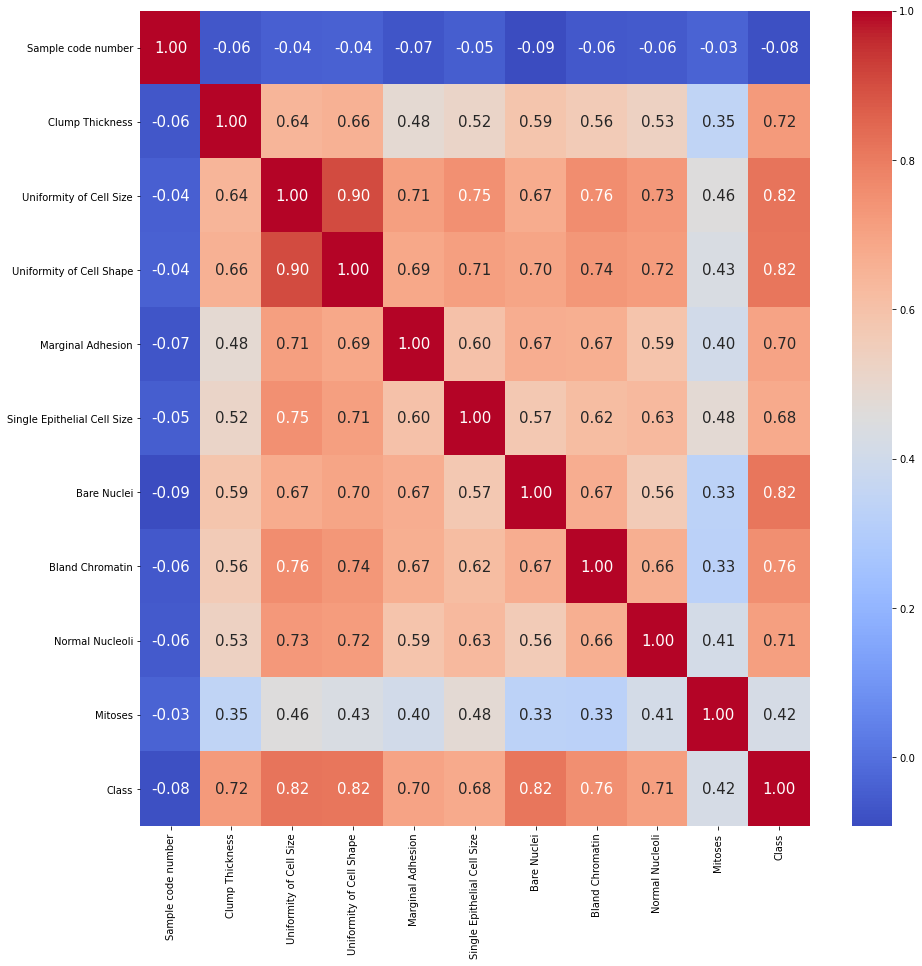

In [96]:
corr = df.corr()
plt.figure(figsize = (15,15))
sns.heatmap(corr,cbar = True, annot=True,fmt= '.2f',
            annot_kws={'size': 15},cmap= 'coolwarm')
plt.show()

En este analisis podemos observar que dentro del dataset existen muchas variables que se relacion de manera lineal

Si hacemos un deep dive en las correlacion que existe entre las variables predictoras y la variable a predecir, podemos observar que las mas preponderantes son (+0.70):


1- Uniformity of Cell Size -> 0.82

2- Uniformity of Cell Shape -> 0.82

3- Bare Nuclei -> 0.82

4- Bland chromatin -> 0.76

5- Climp thinkness -> 0.72

6- Normal nucleoli -> 0.71

7- Marginal adhesion -> 0.70



Ahora analizamos la correlacion con el enfoque de la teoria de la informacion (MIC) para ver si hay algun insight nuevo

In [97]:
col_pairs=list(itertools.combinations(df.columns, 2))
df_res = pd.DataFrame()
for a,b in col_pairs:
    mine = MINE(alpha=0.6, c=15, est="mic_approx")
    mine.compute_score(df[a], df[b])
    df_res=df_res.append({"v1":a, "v2":b, "mic":mine.mic()}, ignore_index=True)
df_res.sort_values(by = "mic", ascending = False).head(10)

,mic,v1,v2
26,0.694048,Uniformity of Cell Size,Class
19,0.687718,Uniformity of Cell Size,Uniformity of Cell Shape
33,0.667319,Uniformity of Cell Shape,Class
48,0.601632,Bare Nuclei,Class
51,0.554938,Bland Chromatin,Class
21,0.546264,Uniformity of Cell Size,Single Epithelial Cell Size
44,0.515849,Single Epithelial Cell Size,Class
23,0.508228,Uniformity of Cell Size,Bland Chromatin
28,0.492213,Uniformity of Cell Shape,Single Epithelial Cell Size
22,0.482566,Uniformity of Cell Size,Bare Nuclei


Observamos que el orden de preponderacia en la correlacion de pearson y MIC son bastante similares

Luego de este analisis, definimos que las variables predictoras que vamos a utilizar son:

1- Uniformity of Cell Size

2- Bare Nuclei

3- Bland chromatin

4- Normal nucleoli

5- Marginal adhesion

6- Climp thinkness

Como se puede observar, quitamos la variable Uniformity of Cell Shape para evitar ser redundantes con la variable Uniformity of Cell Size.

In [98]:
df_ml = df.drop(columns=["Sample code number","Uniformity of Cell Shape","Single Epithelial Cell Size","Mitoses"])

Graficamos la distribucion de todas las variables que elegimos para predecir, dependiendo si el tumor es maligno o beningno

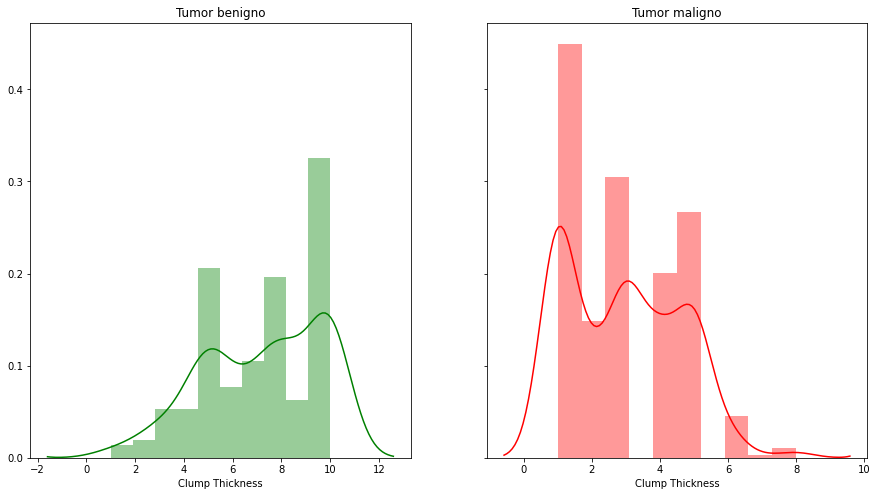

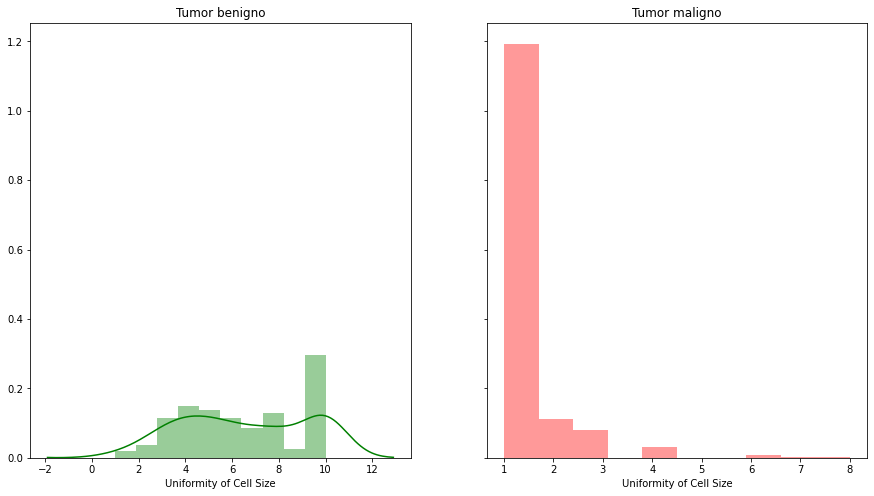

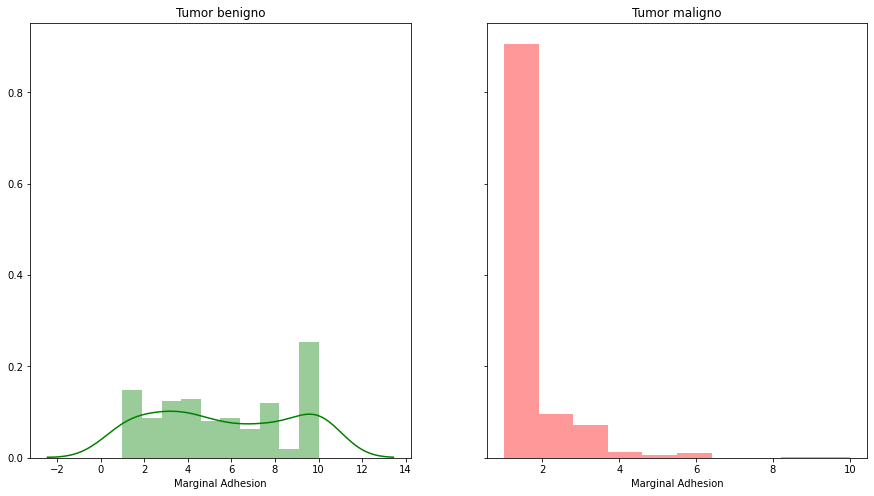

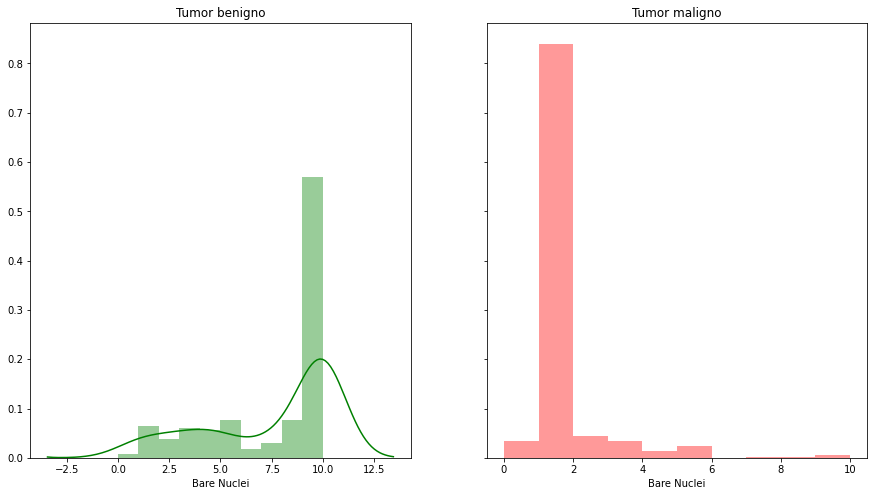

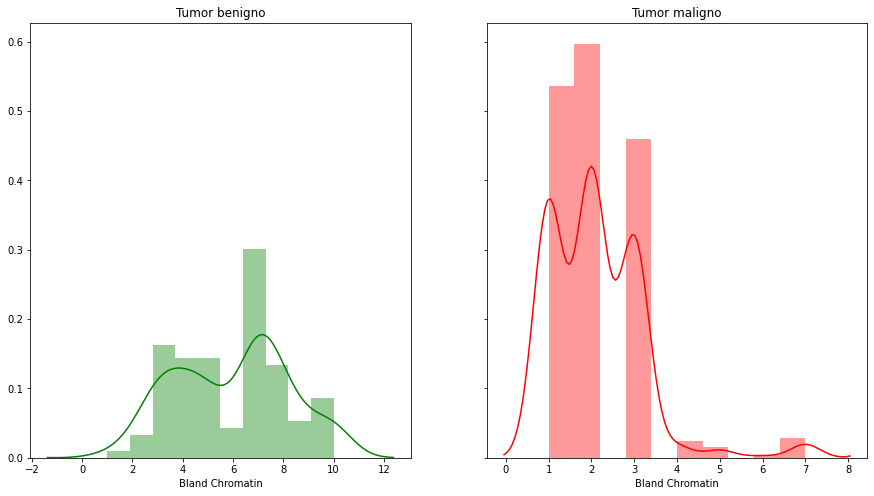

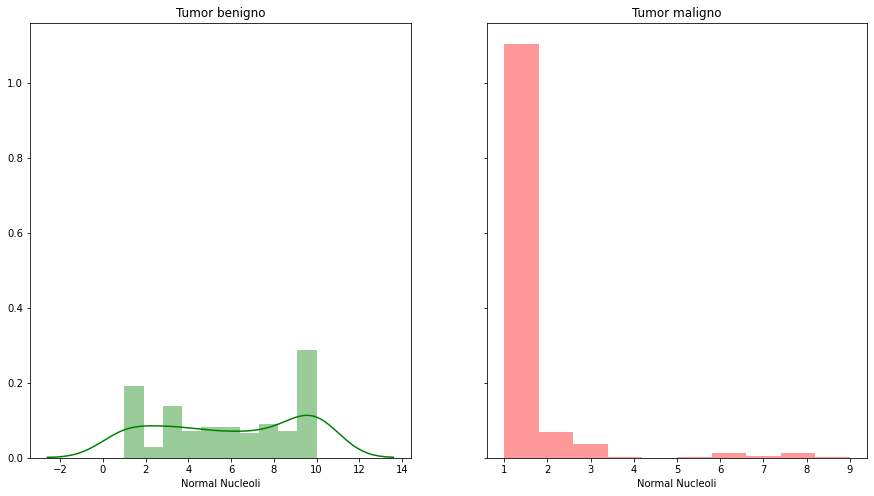

In [99]:
pos = df_ml["Class"] == 1
neg = df_ml["Class"] == 0

variables = ["Clump Thickness","Uniformity of Cell Size","Marginal Adhesion","Bare Nuclei","Bland Chromatin","Normal Nucleoli"]

col = "Class"

for i in variables:
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,8))
    ax1.set_title('Tumor benigno')
    ax2.set_title('Tumor maligno')
    sns.distplot(df_ml[pos][i],bins = 10, rug=False, hist=True, kde = True ,ax =ax1,color = "g")
    sns.distplot(df_ml[neg][i],bins = 10, rug=False, hist=True, kde = True ,ax =ax2,color = "r")
   
    #plt.subplots_adjust(wspace=2, bottom=0.3)
    plt.show()

# Parte 3: Implementacion de un modelo de ML en forma de benchmark - Arbol de decisión

Creamos las variables predictoras y la variable a predecir y hacemos la division en test y train. Se usa el stratify para realizar la division del dataset de manera balanceda respecto a la variable a predecir

In [100]:
X = df_ml.drop(columns=["Class"])
y = df_ml["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,stratify = df["Class"])

In [101]:
print('Proporcion de tumores malignos en los datos de Train: ', y_train.sum()/y_train.size)
print('Proporcion de tumores malignos en los datos de Test: ', y_test.sum()/y_test.size)

Proporcion de tumores malignos en los datos de Train:  0.36046511627906974
Proporcion de tumores malignos en los datos de Test:  0.35658914728682173


Creamos una funcion que devuelva algunas de las metricas del modelo

In [102]:
def clasification_metrics (y_test, y_pred, pos_label = 1):
    accuracy = accuracy_score(y_test,y_test_pred)
    f1 = f1_score(y_test,y_test_pred, pos_label = pos_label)
    precision = precision_score(y_test,y_test_pred, pos_label = pos_label)
    recall = recall_score(y_test,y_test_pred, pos_label = pos_label)
    return [accuracy, f1, precision, recall]

Creamos el modelo de arbol de decisión y vamos iternado el hiperparametro de profundidad

In [103]:
lista_accuracy_train = []
lista_accuracy_test = []


profundidades = [1,2,3,4,5,6,7,8,9,10]


for k in profundidades:
        
    tree = DecisionTreeClassifier(max_depth = k,random_state=42)
    
   
    tree.fit(X_train,y_train)
    
    
    y_train_pred = tree.predict(X_train)
    train_acc = accuracy_score(y_train_pred,y_train)
    
   
    y_test_pred = tree.predict(X_test)
    test_acc = accuracy_score(y_test_pred,y_test)
    
    
    lista_accuracy_train.append(train_acc)
    lista_accuracy_test.append(test_acc)
    
    
    if k == 5:
        
        X_train_optimo = X_train
        X_test_optimo = X_test
        y_train_pred_optimo = y_train_pred
        y_test_pred_optimo = y_test_pred
        
        

Graficamos el resultado de la metrica de accuracy para train y test con las distintas profundidades

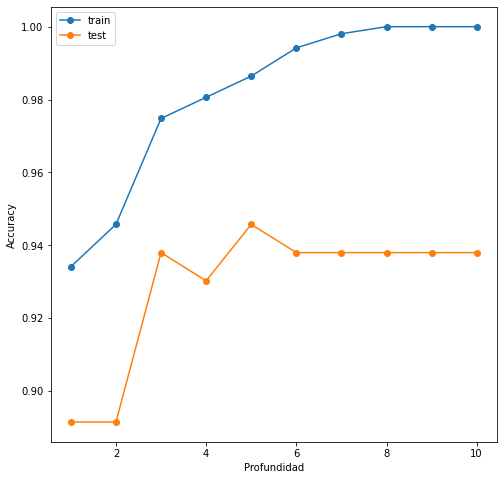

In [104]:
plt.figure(figsize=(8,8))
plt.plot(profundidades,lista_accuracy_train,'o-',label='train' )
plt.plot(profundidades,lista_accuracy_test,'o-',label='test')
plt.legend()
plt.xlabel("Profundidad")
plt.ylabel("Accuracy")
plt.show()

Se puede observar que teniendo en cuenta el accuracy del modelo, performa mejor con una profundidad igual a 5. Veamos el resultado de otras metricas:

Accuracy para Tree: 0.94
Precision para Tree: 0.90
Recall para Tree: 0.93
F1 para Tree: 0.91




<Figure size 720x576 with 0 Axes>

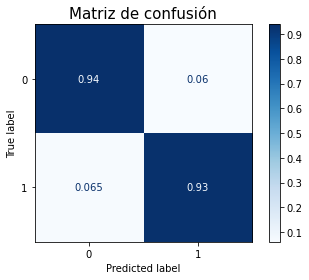

In [105]:
print("Accuracy para Tree: %0.2f" % (clasification_metrics(y_test,y_test_pred_optimo)[0]))
print("Precision para Tree: %0.2f" % (clasification_metrics(y_test,y_test_pred_optimo)[2]))
print("Recall para Tree: %0.2f" % (clasification_metrics(y_test,y_test_pred_optimo)[3]))
print("F1 para Tree: %0.2f" % (clasification_metrics(y_test,y_test_pred_optimo)[1]))
print ("\n")
plt.figure(figsize=(10,8))
plot_confusion_matrix(tree,X_test, y_test,cmap=plt.cm.Blues,normalize='true')

plt.title("Matriz de confusión",size = 15)
plt.show()

# Parte 4: Implementacion de tres modelos de ML con un tunning de los hiperparametros

## Arbol de decisión

Creamos el modelo, un diccionario con los hiperparametros a probar y la lista de metricas que tiene que devolver el modelo

In [106]:
gs_tree = DecisionTreeClassifier()
param_grid = {'criterion':['gini','entropy'],
              'max_depth': np.arange(1,10), 
              'min_samples_split': np.arange(2,10),
              'min_samples_leaf': np.arange(1,5)
             }
scoring2 = ['accuracy','roc_auc','recall','f1']

Creamos el modelo de GS y lo entrenamos

In [107]:
model = GridSearchCV(gs_tree, param_grid=param_grid, cv=5,scoring = scoring2 ,refit='roc_auc')
model.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_leaf': array([1, 2, 3, 4]),
                         'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
             refit='roc_auc', scoring=['accuracy', 'roc_auc', 'recall', 'f1'])

Algunos de sus resultados son:

In [108]:
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

scores = pd.DataFrame(model.cv_results_)
scores.head()

Mejores parametros: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 6}
Mejor Score: 0.9846027846027846



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_accuracy,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.002979,0.000630,0.005390,0.001027,gini,1,1,2,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.932692,...,0.055173,395,0.909091,0.906667,0.923077,0.886076,0.895522,0.904087,0.01257,528
1,0.001822,0.000767,0.003778,0.000730,gini,1,1,3,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.932692,...,0.055173,395,0.909091,0.906667,0.923077,0.886076,0.895522,0.904087,0.01257,528
2,0.001590,0.000492,0.003589,0.000479,gini,1,1,4,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.932692,...,0.055173,395,0.909091,0.906667,0.923077,0.886076,0.895522,0.904087,0.01257,528
3,0.001595,0.000486,0.003586,0.000488,gini,1,1,5,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.932692,...,0.055173,395,0.909091,0.906667,0.923077,0.886076,0.895522,0.904087,0.01257,528
4,0.001591,0.000487,0.003389,0.000489,gini,1,1,6,"{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.932692,...,0.055173,395,0.909091,0.906667,0.923077,0.886076,0.895522,0.904087,0.01257,528


Hacemos la prediccion con los datos de test con el modelo que tiene los hiperparametros con mejores resultados

In [109]:
y_test_pred = model.predict(X_test)

Algunas de sus metricas de performance son:

Accuracy para Tree: 0.94
Precision para Tree: 0.87
Recall para Tree: 0.98
F1 para Tree: 0.92




<Figure size 720x576 with 0 Axes>

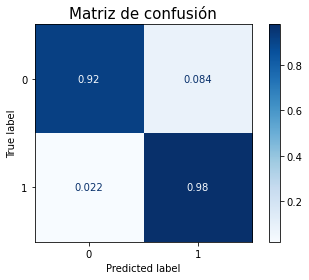

In [110]:
print("Accuracy para Tree: %0.2f" % (clasification_metrics(y_test,y_test_pred)[0]))
print("Precision para Tree: %0.2f" % (clasification_metrics(y_test,y_test_pred)[2]))
print("Recall para Tree: %0.2f" % (clasification_metrics(y_test,y_test_pred)[3]))
print("F1 para Tree: %0.2f" % (clasification_metrics(y_test,y_test_pred)[1]))
print ("\n")
plt.figure(figsize=(10,8))
plot_confusion_matrix(model,X_test, y_test,cmap=plt.cm.Blues,normalize='true')

plt.title("Matriz de confusión",size = 15)
plt.show()

Vamos a analizar los resultados de la curva ROC

In [111]:
y_score = model.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)
roc_auc

0.9709271870089051

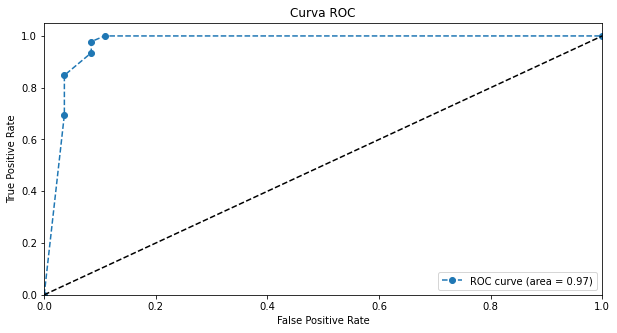

In [112]:
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr,'o--', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Una primera conclusion es, que a pesar de usar el mismo modelo se mejoraron los resultados respecto al modelo de benchmark.

El resultado de la curva ROC demuestra que este modelo tiene un 97% de probabilidad de distinguir los tumores malignos.

## Vecinos mas cercanos

Creamos el modelo, un diccionario con los hiperparametros a probar y la lista de metricas que tiene que devolver el modelo

In [113]:
knn = KNeighborsClassifier()
param_grid2 = {'n_neighbors':np.arange(1, 20),
              'weights': ['uniform', 'distance'], 
              'leaf_size':[1,3,5,7,10],
              'algorithm':['auto', 'kd_tree']}

scoring = ['accuracy','roc_auc','recall','f1']

Creamos el modelo de GS y lo entrenamos

In [114]:
model_knn = GridSearchCV(knn, param_grid=param_grid2, cv=5,scoring = scoring ,refit='roc_auc')
model_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'leaf_size': [1, 3, 5, 7, 10],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'weights': ['uniform', 'distance']},
             refit='roc_auc', scoring=['accuracy', 'roc_auc', 'recall', 'f1'])

Algunos de sus resultados son:

In [115]:
print("Mejores parametros: "+str(model_knn.best_params_))
print("Mejor Score: "+str(model_knn.best_score_)+'\n')

scores_knn = pd.DataFrame(model_knn.cv_results_)
scores_knn.head()

Mejores parametros: {'algorithm': 'auto', 'leaf_size': 3, 'n_neighbors': 15, 'weights': 'distance'}
Mejor Score: 0.9942669942669944



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_n_neighbors,param_weights,params,split0_test_accuracy,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.002798,0.000986,0.009362,0.001195,auto,1,1,uniform,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",1.000000,...,0.039721,185,1.000000,0.929577,0.906667,0.935065,0.957746,0.945811,0.031592,341
1,0.002193,0.000399,0.005781,0.000399,auto,1,1,distance,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",1.000000,...,0.039721,185,1.000000,0.929577,0.906667,0.935065,0.957746,0.945811,0.031592,341
2,0.002192,0.000398,0.008773,0.001163,auto,1,2,uniform,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.971154,...,0.017115,371,0.958904,0.942857,0.918919,0.933333,0.957746,0.942352,0.015111,371
3,0.001994,0.000002,0.005979,0.000001,auto,1,2,distance,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.990385,...,0.032599,257,0.986667,0.929577,0.906667,0.935065,0.957746,0.943144,0.027156,361
4,0.002391,0.000483,0.007784,0.000738,auto,1,3,uniform,"{'algorithm': 'auto', 'leaf_size': 1, 'n_neigh...",0.980769,...,0.013417,1,0.973684,0.972222,0.935065,0.921053,0.972222,0.954849,0.022325,63


Hacemos la prediccion con los datos de test con el modelo que tiene los hiperparametros con mejores resultados

In [116]:
y_test_pred_knn = model_knn.predict(X_test)

Algunas de sus metricas de performance son:

Accuracy para Knn: 0.94
Precision para Knn: 0.87
Recall para Knn: 0.98
F1 para Knn: 0.92




<Figure size 720x576 with 0 Axes>

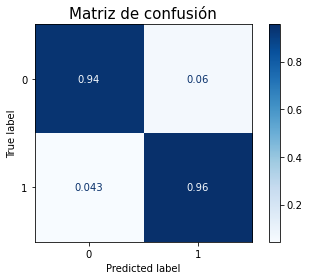

In [117]:
print("Accuracy para Knn: %0.2f" % (clasification_metrics(y_test,y_test_pred_knn)[0]))
print("Precision para Knn: %0.2f" % (clasification_metrics(y_test,y_test_pred_knn)[2]))
print("Recall para Knn: %0.2f" % (clasification_metrics(y_test,y_test_pred_knn)[3]))
print("F1 para Knn: %0.2f" % (clasification_metrics(y_test,y_test_pred_knn)[1]))
print("\n")

plt.figure(figsize=(10,8))
plot_confusion_matrix(model_knn,X_test, y_test,cmap=plt.cm.Blues,normalize='true')

plt.title("Matriz de confusión",size = 15)
plt.show()

Vamos a analizar los resultados de la curva ROC

In [118]:
y_score_knn = model_knn.predict_proba(X_test)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_score_knn[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_knn

0.9800942902042954

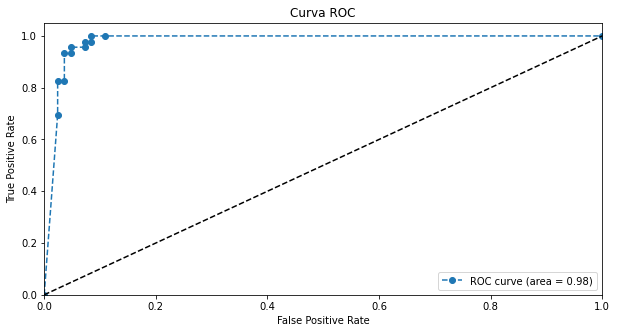

In [119]:
plt.figure(figsize=(10,5))
plt.plot(fpr_knn, tpr_knn,'o--', label='ROC curve (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Como una primera conclusion, si comparamos este modelo con el de arbol de decisión se puede observar que tuvo una leve mejora, ya que este modelo puede distinguir los tumores malignos con un 98% de probabilidad (~1%+)

## Regresion logistica

Creamos el modelo, un diccionario con los hiperparametros a probar y la lista de metricas que tiene que devolver el modelo

In [120]:
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],
               'C':[0.001,.009,0.01,.09,1,5,10,25],
               'solver':['newton-cg', 'lbfgs', 'liblinear']}
scoring = ['accuracy','roc_auc','recall','f1']

Entrenamos el modelo

In [121]:
model_rl = GridSearchCV(clf, param_grid=grid_values, cv=5,scoring = scoring ,refit='roc_auc')
model_rl.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             refit='roc_auc', scoring=['accuracy', 'roc_auc', 'recall', 'f1'])

Algunos de los resultados del modelo son:

In [122]:
print("Mejores parametros: "+str(model_rl.best_params_))
print("Mejor Score: "+str(model_rl.best_score_)+'\n')

scores_rl = pd.DataFrame(model_rl.cv_results_)
scores_rl.head()

Mejores parametros: {'C': 0.09, 'penalty': 'l2', 'solver': 'newton-cg'}
Mejor Score: 0.9975429975429975



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_accuracy,split1_test_accuracy,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.000586,0.000478,0.000000,0.000000e+00,0.001,l1,newton-cg,"{'C': 0.001, 'penalty': 'l1', 'solver': 'newto...",NaN,NaN,...,NaN,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48
1,0.000589,0.000481,0.000000,0.000000e+00,0.001,l1,lbfgs,"{'C': 0.001, 'penalty': 'l1', 'solver': 'lbfgs'}",NaN,NaN,...,NaN,34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
2,0.002196,0.000373,0.004973,1.402266e-03,0.001,l1,liblinear,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.634615,0.640777,...,0.000000,32,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32
3,0.008160,0.001156,0.004387,4.902134e-04,0.001,l2,newton-cg,"{'C': 0.001, 'penalty': 'l2', 'solver': 'newto...",0.971154,0.970874,...,0.013611,30,0.958904,0.957746,0.931507,0.929577,0.942857,0.944118,0.012461,24
4,0.005036,0.000105,0.003986,9.464947e-07,0.001,l2,lbfgs,"{'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}",0.971154,0.970874,...,0.013611,30,0.958904,0.957746,0.931507,0.929577,0.942857,0.944118,0.012461,24


Hacemos la prediccion con los datos de test con el modelo que tiene los hiperparametros con mejores resultados

In [123]:
y_test_pred_rl = model_rl.predict(X_test)

Algunas de sus metricas de performance son:

Accuracy para RL: 0.94
Precision para RL: 0.87
Recall para RL: 0.98
F1 para RL: 0.92




<Figure size 720x576 with 0 Axes>

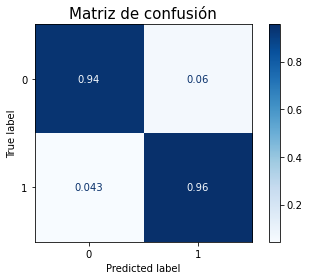

In [124]:
print("Accuracy para RL: %0.2f" % (clasification_metrics(y_test,y_test_pred_rl)[0]))
print("Precision para RL: %0.2f" % (clasification_metrics(y_test,y_test_pred_rl)[2]))
print("Recall para RL: %0.2f" % (clasification_metrics(y_test,y_test_pred_rl)[3]))
print("F1 para RL: %0.2f" % (clasification_metrics(y_test,y_test_pred_rl)[1]))
print("\n")

plt.figure(figsize=(10,8))
plot_confusion_matrix(model_rl,X_test, y_test,cmap=plt.cm.Blues,normalize='true')

plt.title("Matriz de confusión",size = 15)
plt.show()

Vamos a analizar los resultados de la curva ROC

In [125]:
y_score_rl = model_rl.predict_proba(X_test)

fpr_rl, tpr_rl, _ = roc_curve(y_test, y_score_rl[:, 1])
roc_auc_rl = auc(fpr_rl, tpr_rl)
roc_auc_rl

0.9895233106338396

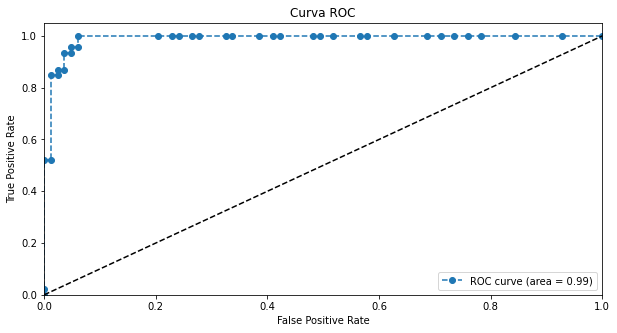

In [126]:
plt.figure(figsize=(10,5))
plt.plot(fpr_rl, tpr_rl,'o--', label='ROC curve (area = %0.2f)' % roc_auc_rl)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

Una primera conclusion podria ser que, el modelo que mayor probabilidad tiene de detectar un tumor como maligno es la regresion logistica, con un 99%

Ya definimos que el modelo que mejor puede diferenciar los tumores malignos es la regresion logistica, ahora tenemos que encontrar cual es el threshold ideal para asegurarnos de clasificar el 100% de los tumores malignos como tal, ya que si clasificaramos un tumor maligno como benigno, seria el riesgo mas grande que podemos incurrir.

In [127]:
@interact(punto_corte=(0, 1, 0.01), model=['regresion logistica'])

def f2(model, punto_corte=0.5):
    if(model=='regresion logistica'):
        sel_model=y_score_rl
    else:
        pass

    y_pred_2=np.where(sel_model>punto_corte, 1, 0)
    conf_mat=pd.crosstab(y_test, y_pred_2[:,1], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(conf_mat, annot=True, fmt='g')


    res = precision_recall_fscore_support(y_test, y_pred_2[:,1], average='binary')

    print("\nPrecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % (res[0], res[1], res[2], accuracy_score(y_test, y_pred_2[:,1])))

interactive(children=(Dropdown(description='model', options=('regresion logistica',), value='regresion logisti…

Ubicando el threshold en 0.33 logramos clasificar todos los tumores malignos correctamente

# Parte 5: Conclusiones

Con el dataset trabajado, encontramos un modelo que predice muy bien los tumores maliganos

El mejor modelo es una regresion logistica con los siguientes hiperparametros:
{'C': 0.09, 'penalty': 'l2', 'solver': 'newton-cg'}

Ese modelo con un valor de corte o threshold en 0.33 es el mejor predictor

# Parte 6: Anexo: threshold para todos los modelos

In [128]:
@interact(punto_corte=(0, 1, 0.01), model=['tree','knn','regresion logistica'])

def f2(model, punto_corte=0.5):
    if(model=='tree'):
        sel_model=y_score
    elif(model=='knn'):
        sel_model=y_score_knn
    else:
        sel_model=y_score_rl

    y_pred_2=np.where(sel_model>punto_corte, 1, 0)
    conf_mat=pd.crosstab(y_test, y_pred_2[:,1], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(conf_mat, annot=True, fmt='g')


    res = precision_recall_fscore_support(y_test, y_pred_2[:,1], average='binary')

    print("\nPrecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % (res[0], res[1], res[2], accuracy_score(y_test, y_pred_2[:,1])))

interactive(children=(Dropdown(description='model', options=('tree', 'knn', 'regresion logistica'), value='tre…

El mejor threshold para los distintos modelos son los siguientes:

1-Arbol de decisión: 0.16

2-Knn: 0.13

3-Regresion logistica: 0.33